# AIC-403 Lab 2: Experiment Tracking

CMKL University

By Sarun Gulyanon


### Goal

Be able to apply and fine-tune classification and regression models, use regularization techniques to improve performance, and track experiments using tools such as MLflow and Weights & Biases (W&B).


### Outline

In this lab, we will review the regularization concept and explore experiment tracking and visualization tools.

1. Regularization
2. MLflow Tutorial


__References__
1. https://colab.research.google.com/github/ageron/handson-ml3/blob/main/04_training_linear_models.ipynb#scrollTo=yCzGt0L_cDTF
2. https://mlflow.org/docs/latest/ml/traditional-ml/sklearn/guide/

----

# 0. Setting Up Working Environment

Install neceesary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Regularization

Regularization is a technique used to prevent overfitting in machine learning models. For linear models, this can be achieved by adding a penalty term to the loss function.

- **L1 Regularization (Lasso)**: adds the sum of absolute values of weights to the loss function, promoting sparsity (many weights become zero).
- **L2 Regularization (Ridge)**: adds the sum of squared weights to the loss function, encouraging small weights without forcing them to zero.

In this lab, we will work with the synthetic data.

In [2]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

X_new = np.linspace(-3, 3, 100).reshape(100, 1)

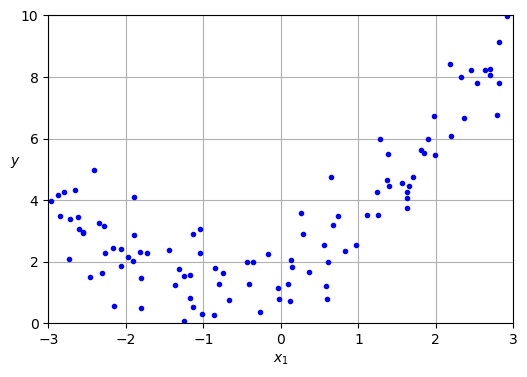

In [3]:
# Display the synthetic data
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

First, we will fit a linear regression model to the synthetic data without any regularization.

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

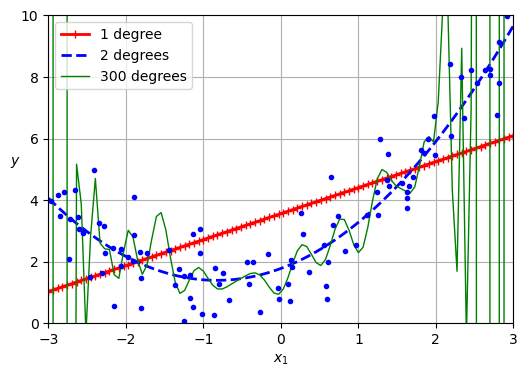

In [5]:
plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

Next, we will apply L1 and L2 regularization to the linear regression model using different alpha values and compare the results.

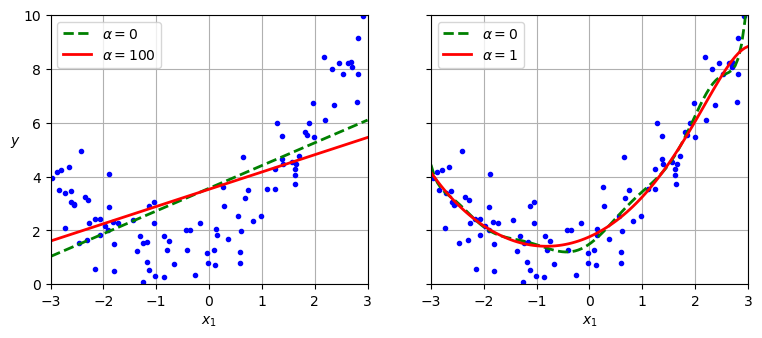

In [6]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([-3, 3, 0, 10])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

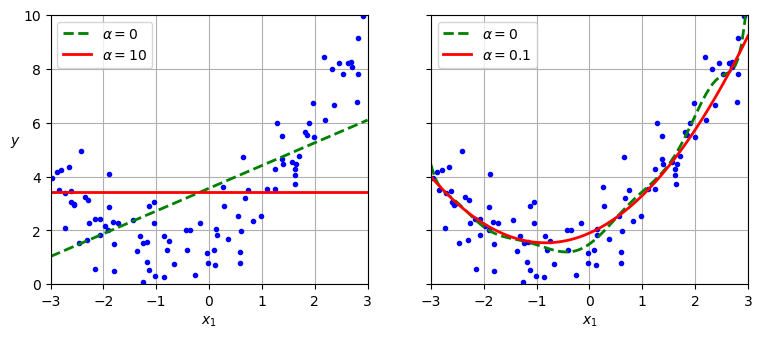

In [7]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 10), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 0.1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

### **Question**: 
How does the value of alpha affect the model when it is large versus small?

# 2. MLflow Tutorial

MLflow with scikit-learn allows you to track experiments by logging model parameters, metrics, and artifacts (i.e., trained models, plots, datasets, logs, or reports). You can easily compare different runs, monitor performance, and save models, making it easier to reproduce and manage machine learning experiments.

In [8]:
from sklearn.model_selection import train_test_split

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.3, random_state=42)

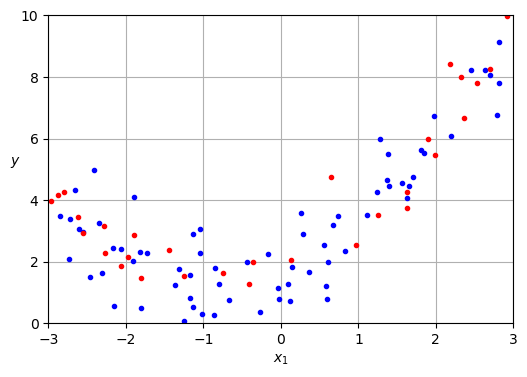

In [9]:
# Display the synthetic data
plt.figure(figsize=(6, 4))
plt.plot(X_train_reg, y_train_reg, "b.")
plt.plot(X_test_reg, y_test_reg, "r.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

In [10]:
import mlflow
from sklearn.model_selection import GridSearchCV

mlflow.set_tracking_uri('http://localhost:5000')

# Create or set experiment
experiment_name = "ridge-optimization"
mlflow.set_experiment(experiment_name)

# Enable autologging with hyperparameter tuning support
mlflow.sklearn.autolog(max_tuning_runs=3)  # Track top 3 parameter combinations

# Define parameter grid
param_grid = {
    "ridge__alpha": [0.5, 1.0, 2.0],
    "polynomialfeatures__degree": [5, 10, 15],
}

with mlflow.start_run(run_name="Ridge Regression Hyperparameter Tuning"):
    # Create and fit GridSearchCV
    pipeline = make_pipeline(
        PolynomialFeatures(degree=5, include_bias=False),  # start with degree=2 as default
        StandardScaler(),
        Ridge()
    )

    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1
    )

    grid_search.fit(X_train_reg, y_train_reg)

    # Best model evaluation
    best_score = grid_search.score(X_test_reg, y_test_reg)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    print(f"Test score: {best_score:.3f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


2025/08/14 15:33:23 INFO mlflow.sklearn.utils: Logging the 3 best runs, 6 runs will be omitted.


🏃 View run gaudy-ant-431 at: http://localhost:5000/#/experiments/157957060375297808/runs/51ebfb39e25a4bcab4dce23237a245cc
🧪 View experiment at: http://localhost:5000/#/experiments/157957060375297808
🏃 View run bemused-lynx-260 at: http://localhost:5000/#/experiments/157957060375297808/runs/07f0f70b3d674775b2953b8658a25aff
🧪 View experiment at: http://localhost:5000/#/experiments/157957060375297808
🏃 View run nebulous-stoat-918 at: http://localhost:5000/#/experiments/157957060375297808/runs/e967c57a30664ab98e9316f9569a4c9d
🧪 View experiment at: http://localhost:5000/#/experiments/157957060375297808
Best parameters: {'polynomialfeatures__degree': 5, 'ridge__alpha': 0.5}
Best cross-validation score: -0.938
Test score: -0.642
🏃 View run Ridge Regression Hyperparameter Tuning at: http://localhost:5000/#/experiments/157957060375297808/runs/55a8bec547b74903b89f75af02593e48
🧪 View experiment at: http://localhost:5000/#/experiments/157957060375297808


# Exercise

Experiment with different alpha values for both Ridge and Lasso regression models, as well as other hyperparameters, and observe their impact on model performance. Track your results using MLflow or Weights & Biases (W&B).

(Optional) Extend the experiment to other regression models and compare the outcomes.

# Further Reading

- [MLflow Documentation](https://mlflow.org/docs/latest/ml/)

---